In [1]:
import os
import h5py
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from random import randint
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import time

import copy

plt.ion()   # interactive mode

/opt/applications/python/3.6.3/gnu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load data

In [2]:
PATH = "datasets/"
trainHdf5 = f'{PATH}Chong_train_set.hdf5'
traindata = h5py.File(trainHdf5, 'r')
valHdf5 = f'{PATH}Chong_valid_set.hdf5'
valdata = h5py.File(valHdf5, 'r')
testHdf5 = f'{PATH}Chong_test_set.hdf5'
testdata = h5py.File(testHdf5, 'r')

In [3]:
traindata['label_names'].shape

(21882,)

In [4]:
classes = sorted(list(set([y for y in traindata['label_names']])))
idx_to_class = {classes.index(x):x.decode("utf-8")  for x in classes}

In [5]:
class ChongSet(Dataset):
    
    def __init__(self, hdf5, transform=None):
        classes = sorted(list(set([y for y in hdf5['label_names']])))
        class_to_idx = {x: classes.index(x) for x in classes}
        
        imgs = hdf5['data1']
        labels = hdf5['label_names']
        self.transform = transform
        self.classes = classes
        self.class_to_idx = class_to_idx
        self.imgs = imgs
        self.labels = labels
        self.data = []
        
        for i in range(len(imgs)):
            tmp = (np.array(imgs[i,:]).reshape(2,64,64).T, labels[i])
            self.data.append(tmp)
  
        
    def __len__(self):
        return(self.imgs.shape[0])
    
    def __getitem__(self, idx):
        img, cls = self.data[idx]
        cls = self.class_to_idx[cls]

        if self.transform:
            img = self.transform(img)
       
        return(img, cls)

In [6]:
import random
class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image= sample

        h, w = image.shape[:2]
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        return image


class FlipLeftRight(object):

    def __call__(self, sample):
        image= sample
        #h,w,c = image.shape
        if random.random() < 0.5:
            return(np.flip(image, 0).copy())
        else:
            return(image)
        
class UpLeftDown(object):

    def __call__(self, sample):
        image= sample
        #h,w,c = image.shape
        if random.random() < 0.5:
            return(np.flip(image, 1).copy())
        else:
            return(image)
        
class RandomRotate(object):
    
    def __call__(self, sample):
        image = sample
        u = randint(0,3)
        return(np.rot90(image, u, (0,1)).copy())

In [7]:
data_transforms = {
    'train': transforms.Compose([
        RandomCrop(60),
        FlipLeftRight(),
        UpLeftDown(),
        RandomRotate(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5], [0.5, 0.5])
    ]),
    'val':transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5], [0.5, 0.5])
    ]),
    'test':transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5], [0.5, 0.5])
    ]),
}

In [8]:
image_datasets = {'train': ChongSet(traindata, transform = data_transforms['train'] ), 'val': ChongSet(valdata, transform = data_transforms['val']), 'test': ChongSet(valdata, transform = data_transforms['test'])}
image_datasets

{'test': <__main__.ChongSet at 0x7f05d0b41e80>,
 'train': <__main__.ChongSet at 0x7f05d0b32c50>,
 'val': <__main__.ChongSet at 0x7f05d08d4828>}

In [9]:
image_datasets['train'].imgs.shape

(21882, 8192)

In [10]:
dataloaders = {x:torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataloaders

{'test': <torch.utils.data.dataloader.DataLoader at 0x7f05d01f70f0>,
 'train': <torch.utils.data.dataloader.DataLoader at 0x7f05d0b32fd0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f05d0b329b0>}

In [11]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
dataset_sizes

{'test': 4491, 'train': 21882, 'val': 4491}

In [12]:
image_datasets['train'].class_to_idx

{b'ACTIN': 0,
 b'BUDNECK': 1,
 b'BUDTIP': 2,
 b'CELLPERIPHERY': 3,
 b'CYTOPLASM': 4,
 b'DEAD': 5,
 b'ENDOSOME': 6,
 b'ER': 7,
 b'GHOST': 8,
 b'GOLGI': 9,
 b'MITOCHONDRIA': 10,
 b'NUCLEARPERIPHERY': 11,
 b'NUCLEI': 12,
 b'NUCLEOLUS': 13,
 b'PEROXISOME': 14,
 b'SPINDLE': 15,
 b'SPINDLEPOLE': 16,
 b'VACUOLARMEMBRANE': 17,
 b'VACUOLE': 18}

In [13]:
use_gpu = torch.cuda.is_available()
use_gpu

True

/opt/applications/python/3.6.3/gnu/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


17

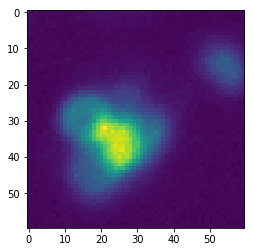

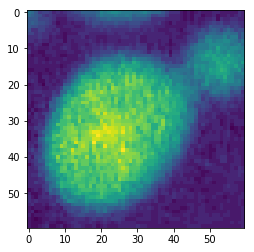

In [14]:
inputs, classes = next(iter(dataloaders['train']))

f = plt.figure(0)
plt.imshow(inputs[0,0,:,:])
f.show()

g=plt.figure(1)
plt.imshow(inputs[0,1, :,:])
g.show()

classes[0]

## Train model

In [15]:
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [16]:
class Deeploc(nn.Module):
    def __init__(self):
        super(Deeploc, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(2, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 64, 3, padding =1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2, padding = 1)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding =1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 128, 3, padding = 1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2, padding = 1)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv6 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU() 
        )
        self.conv7 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.conv8 = nn.Sequential(
            nn.Conv2d(256, 256, 3, padding = 1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc1 = nn.Sequential(
            nn.Linear(8*8*256, 512),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 512),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.logit = nn.Linear(512, 19)

        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.conv8(x)
        x = x.view(-1, 8*8*256)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.logit(x)
        
        return x
        
        

In [17]:
model = Deeploc()
model = model.cuda()

In [18]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        # Each epoch
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)
            else:
                model.train(False)

            running_loss = 0.0
            running_corrects = 0.0

            # Iterate over data
            for idx, data in enumerate(dataloaders[phase]):
                inputs, labels = data[0], data[1]

                # wrap in variable
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs,labels = Variable(inputs), Variable(labels)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                #backward
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data[0]*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc:{:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.99))
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

In [25]:
model.load_state_dict(torch.load('ChongSet6.pt'))

In [26]:
train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=35)

Epoch 0/34
----------


RuntimeError: CUDNN_STATUS_ARCH_MISMATCH

In [23]:
print(torch.backends.cudnn.is_acceptable(torch.cuda.FloatTensor(1)))
print(torch.backends.cudnn.version())

True
7005


In [23]:
torch.save(model.state_dict(), 'ChongSet7.pt')

In [24]:
model.load_state_dict(torch.load('ChongSet7.pt'))

## Predict data

In [25]:
testlabel = testdata['label_names'][()]

In [26]:
unique, counts = np.unique(testlabel, return_counts=True)
dict(zip(unique, counts))

{b'ACTIN': 93,
 b'BUDNECK': 68,
 b'BUDTIP': 42,
 b'CELLPERIPHERY': 54,
 b'CYTOPLASM': 288,
 b'DEAD': 95,
 b'ENDOSOME': 222,
 b'ER': 532,
 b'GHOST': 180,
 b'GOLGI': 197,
 b'MITOCHONDRIA': 643,
 b'NUCLEARPERIPHERY': 265,
 b'NUCLEI': 572,
 b'NUCLEOLUS': 398,
 b'PEROXISOME': 124,
 b'SPINDLE': 24,
 b'SPINDLEPOLE': 302,
 b'VACUOLARMEMBRANE': 197,
 b'VACUOLE': 220}

In [55]:
actual = []
predict = []
    

In [42]:
labels


 13
  8
  6
 17
[torch.LongTensor of size 4]

In [27]:
def variable2value(variable):
    return(variable.cpu().data.numpy()[0])

def pred_analysis(dataset):
    pred_correct = {}
    pred_wrong = {}
    for i in range(19):
        pred_correct[i]=0
        pred_wrong[i]=0

    for i, data in enumerate(dataset):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data,1)

        for j in range(len(labels)):
            if preds[j] == variable2value(labels[j]):
                pred_correct[variable2value(labels[j])]+=1
            elif preds[j] != variable2value(labels[j]):
                pred_wrong[variable2value(labels[j])]+=1
    return pred_correct, pred_wrong

def pred_summary(dataset):
    pred_correct, pred_wrong = pred_analysis(dataloaders['test'])
    pred_summary = pd.DataFrame()
    pred_summary['label'] = np.array(range(19))
    pred_summary['name'] = pred_summary['label'].map(idx_to_class)
    pred_summary['correct'] = pred_summary['label'].map(pred_correct)
    pred_summary['wrong'] = pred_summary['label'].map(pred_wrong)
    pred_summary['total'] = pred_summary['correct'] + pred_summary['wrong']
    pred_summary = pred_summary.append(pred_summary.sum(numeric_only=True), ignore_index=True)
    pred_summary['rate'] = pred_summary['correct']/pred_summary['total']
    
    ax = pred_summary[['name', 'rate']].set_index('name').plot(kind='bar', title ="Prediction rate", figsize=(10, 5), legend=True, fontsize=12)
    ax.set_xlabel("Classification", fontsize=12)
    ax.set_ylabel("Correct rate", fontsize=12)
    plt.show()
    return(pred_summary)

In [83]:
def pred_analysis2(dataset, actual, predict):
    for i, data in enumerate(dataset):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data,1)
        
        label = labels.cpu().data.numpy()
        pred = preds.cpu().numpy()
        actual = np.append(actual, label.flatten())
        predict = np.append(predict, pred.flatten())
    return(actual, predict)

def calculate_cf_matrix(actual, predict):
    from sklearn.metrics import confusion_matrix
    actual = np.array([])
    predict = np.array([])
    actual, predict = pred_analysis2(dataloaders['test'], actual, predict)
    cf_matrix = confusion_matrix(list(actual), list(predict))
    cf_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]
    return(cf_matrix)

def plot_confusion_matrix(cm, classes, normalize=False, title = 'Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def bar_chart(cm_)

In [84]:

actual = np.array([])
predict = np.array([])
actual, predict = pred_analysis2(dataloaders['test'], actual, predict)

In [96]:
from sklearn.metrics import confusion_matrix
import itertools
cf_matrix = confusion_matrix(list(actual), list(predict))

Normalized confusion matrix


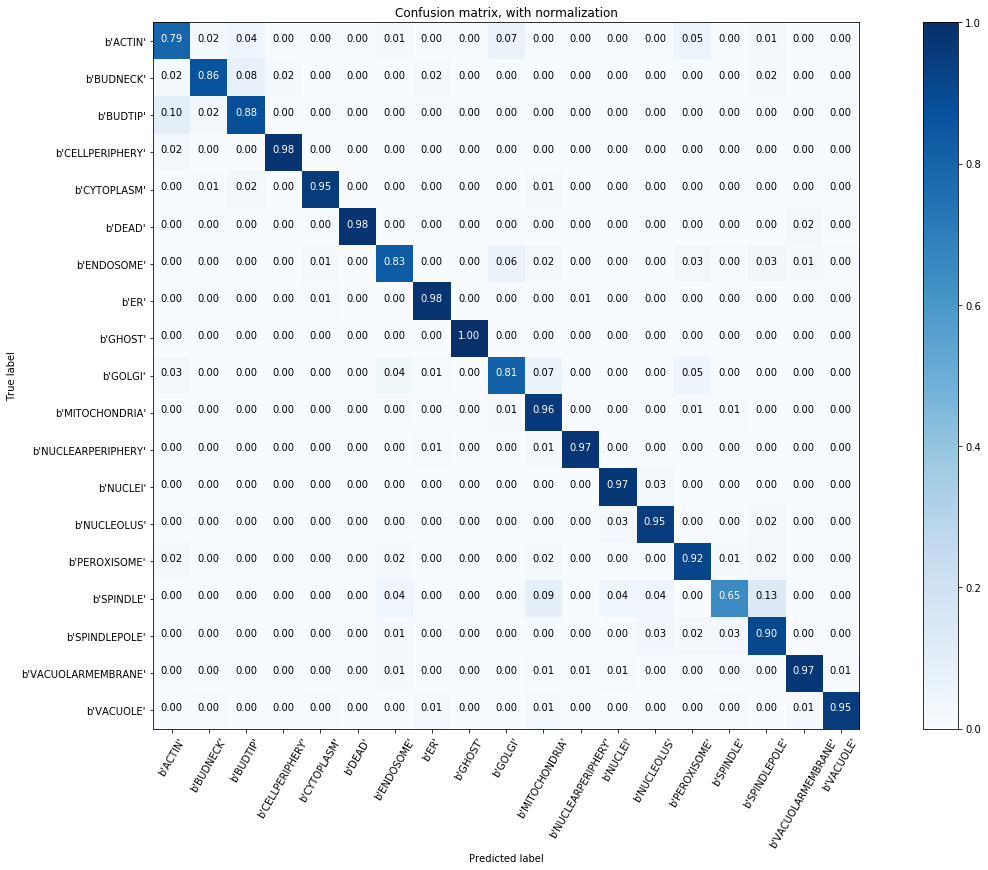

In [108]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=60)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return(cm)

plt.figure(figsize=(18, 12))
cm = plot_confusion_matrix(cf_matrix, classes=classes, normalize= True,
                      title='Confusion matrix, with normalization')
plt.show()

In [109]:
t = cm.diagonal()

In [119]:
t

array([0.79347826, 0.86363636, 0.88095238, 0.98076923, 0.95470383,
       0.97849462, 0.83181818, 0.97924528, 1.        , 0.81218274,
       0.96105919, 0.97348485, 0.97022767, 0.94949495, 0.91869919,
       0.65217391, 0.90365449, 0.96923077, 0.94977169])

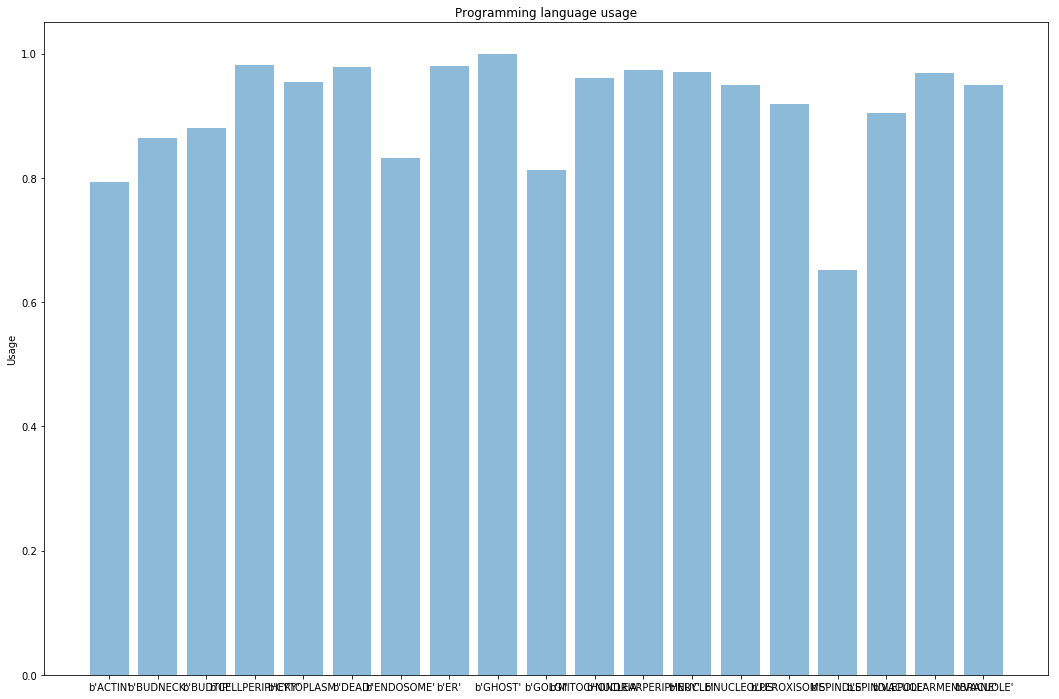

In [118]:
objects = classes
y_pos = np.arange(len(objects))
performance = t
plt.figure(figsize=(18, 12))
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')
 
plt.show()

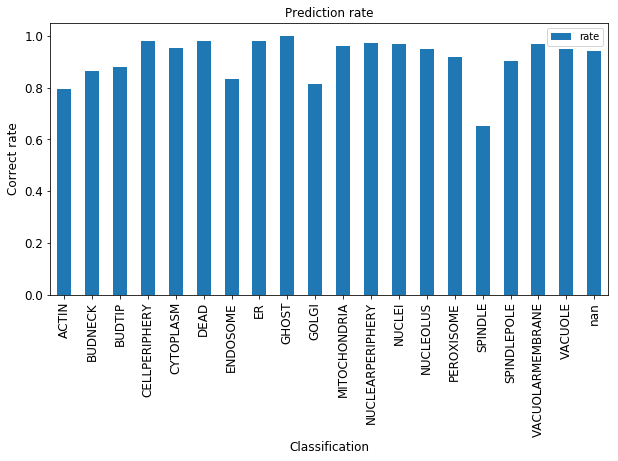

In [28]:
pred_summary= pred_summary(dataloaders['test'])

In [29]:
pred_summary

,label,name,correct,wrong,total,rate
0,0.0,ACTIN,73.0,19.0,92.0,0.793478
1,1.0,BUDNECK,57.0,9.0,66.0,0.863636
2,2.0,BUDTIP,37.0,5.0,42.0,0.880952
3,3.0,CELLPERIPHERY,51.0,1.0,52.0,0.980769
4,4.0,CYTOPLASM,274.0,13.0,287.0,0.954704
5,5.0,DEAD,91.0,2.0,93.0,0.978495
6,6.0,ENDOSOME,183.0,37.0,220.0,0.831818
7,7.0,ER,519.0,11.0,530.0,0.979245
8,8.0,GHOST,178.0,0.0,178.0,1.000000
9,9.0,GOLGI,160.0,37.0,197.0,0.812183
